<a href="https://colab.research.google.com/github/mneedham/data-science-training/blob/master/02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

In this notebook we're going to explore the citation dataset. We should already have installed py2neo, pandas, and matplotlib when setting up our environment, so let's get those imported:

In [1]:
from neo4j import GraphDatabase
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
driver = GraphDatabase.driver("bolt://data-science-training-neo4j", auth=("neo4j", "admin"))        
print(driver.address)

data-science-training-neo4j:7687


## What's in our database?

Now we can run the following query to check how many nodes our database contains:

In [7]:
with driver.session(database="neo4j") as session:
    result = session.run("CALL db.schema.visualization()")
    for row in result:
        for node in row['nodes']:
            print(node)
        
        
        print(f"relationships: {row['relationships']}")

<Node id=-6 labels=frozenset({'Venue'}) properties={'indexes': [], 'name': 'Venue', 'constraints': ['CONSTRAINT ON ( venue:Venue ) ASSERT (venue.name) IS UNIQUE']}>
<Node id=-4 labels=frozenset({'Article'}) properties={'indexes': [], 'name': 'Article', 'constraints': ['CONSTRAINT ON ( article:Article ) ASSERT (article.index) IS UNIQUE']}>
<Node id=-5 labels=frozenset({'Author'}) properties={'indexes': [], 'name': 'Author', 'constraints': ['CONSTRAINT ON ( author:Author ) ASSERT (author.name) IS UNIQUE']}>
relationships: [<Relationship id=-4 nodes=(<Node id=-4 labels=frozenset({'Article'}) properties={'indexes': [], 'name': 'Article', 'constraints': ['CONSTRAINT ON ( article:Article ) ASSERT (article.index) IS UNIQUE']}>, <Node id=-6 labels=frozenset({'Venue'}) properties={'indexes': [], 'name': 'Venue', 'constraints': ['CONSTRAINT ON ( venue:Venue ) ASSERT (venue.name) IS UNIQUE']}>) type='VENUE' properties={}>, <Relationship id=-5 nodes=(<Node id=-4 labels=frozenset({'Article'}) prope

If we run `CALL db.schema()` in the Neo4j Browser (http://localhost:7474/browser/), we'll see the following visualisation:

<img src="images/data-science-training.png" alt="Graph Data Model"/>


Let's drill down a bit. How many nodes do we have for each of these labels?

In [8]:
result = {"label": [], "count": []}
with driver.session(database="neo4j") as session:
    for row in session.run("CALL db.labels()"):
        label = row["label"]
        query = f"MATCH (:`{label}`) RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["label"].append(label)
        result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


We can visualize the counts using matplotlib with the following code:

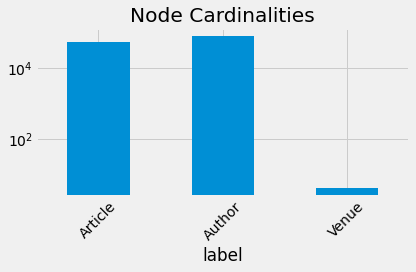

In [9]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And what types of relationships do we have?

In [10]:
result = {"relType": [], "count": []}
with driver.session(database="neo4j") as session:
    for row in session.run("""
    CALL db.relationshipTypes()
YIELD relationshipType
WHERE not relationshipType starts with "CO_AUTHOR"
RETURN relationshipType
    """):
        relationship_type = row["relationshipType"]
        query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["relType"].append(relationship_type)
        result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


We can visualize the counts using matplotlib with the following code:

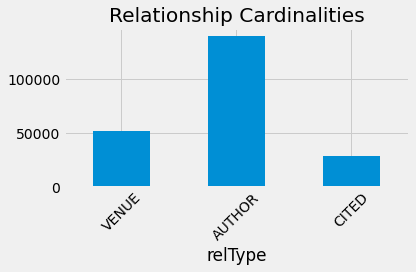

In [11]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.

In [31]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
WITH article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, 
       size((article)<-[:CITED]-()) AS citationsReceived
WHERE citationsGiven > 0 AND citationsReceived > 0
RETURN article, author, citationsGiven, citationsReceived,venue
ORDER BY rand()
LIMIT 25
"""

with driver.session(database="neo4j") as session:
    result = session.run(exploratory_query)
    df = pd.DataFrame([dict(record) for record in result])
    
df

,article,author,citationsGiven,citationsReceived,venue
0,Assessing model-based testing: an empirical st...,Mikael Lindvall,1,1,international conference on software engineering
1,Nonlinear Matrix Diffusion for Optic Flow Esti...,Thomas Brox,1,3,Lecture Notes in Computer Science
2,Finding circles by an array of accumulators,Carolyn Kimme,1,1,Communications of The ACM
3,Nonlinear inverse scale space methods for imag...,Jinjun Xu,1,1,Lecture Notes in Computer Science
4,Intrinsic Evolvable Hardware in Digital Filter...,Yang Zhang,1,1,Lecture Notes in Computer Science
5,A formal semantics for computer languages and ...,Jerome A. Feldman,3,10,Communications of The ACM
6,Test case management tools for accessibility t...,Christophe Strobbe,1,3,Lecture Notes in Computer Science
7,What can context do for web services,Zakaria Maamar,1,1,Communications of The ACM
8,ITTALKS: An Application of Agents in the Seman...,Anupam Joshi,1,1,Lecture Notes in Computer Science
9,Query languages supporting descriptive rule mi...,Cyrille Masson,2,1,Lecture Notes in Computer Science


Let's look into the citation data more closely. We'll write a query that returns the number of citations that each article has, and then create a distribution of those counts using pandas `describe` function:

In [32]:
query = """
MATCH (a:Article)
RETURN size((a)-[:CITED]->()) AS citations
"""

with driver.session(database="neo4j") as session:
    result = session.run(query)
    citation_df = pd.DataFrame([dict(record) for record in result])
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,1.301
min,0.000
25%,0.000
50%,0.000
75%,1.000
90%,2.000
99%,6.000
max,51.000


Most articles are being cited very few times. 99% of articles have 1 citation or less. We do, however, have one article that's been cited more than 200 times. We'll use a log scale histogram to visualise the data;

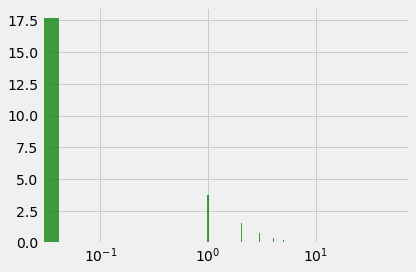

In [33]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise

* Can you create a similar chart showing the articles that cite the most other papers? Note that you'll only need to do a slight tweak of the Cypher query to do this. 
* What about a distribution of the number of articles published by authors?

Keep the results of these exercises handy as they form part of the Check your understanding quiz at the end of this module.